In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def show_img(title, img):
    plt.figure(figsize=(5,5))
    if len(img.shape) == 2:
        plt.imshow(img, cmap='gray')
    else:
        # OpenCV loads in BGR, convert for display
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()
    

In [3]:
def clean_input_image(img_path):
    """
    Steps:
    1. Load image from disk
    2. Resize to a standard width (keeps aspect) so matching is more predictable
    3. Convert to grayscale
    4. Denoise slightly (phone images can be grainy)
    5. Improve contrast
    6. Get a clean binary/edge representation using auto-derived values
    7. Return all important intermediates
    """
    # 1. load
    img = cv2.imread(img_path)
    if img is None:
        raise FileNotFoundError(f"Could not read image at {img_path}")

    target_width = 800
    h, w = img.shape[:2]
    if w > target_width:
        scale = target_width / w
        img = cv2.resize(img, (target_width, int(h * scale)), interpolation=cv2.INTER_AREA)

    # 3. grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    smooth = cv2.bilateralFilter(gray, d=9, sigmaColor=75, sigmaSpace=75)

    # 5. contrast improvement (helps when input is dull / badly lit)
    #    CLAHE derives parameters from local tiles, so less magic-numbery
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(smooth)

    # 6A. automatic threshold (Otsu) – good for near-bimodal images
    #     you can use this for template-ish matching later
    _, th_otsu = cv2.threshold(
        enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )

    # 6B. auto Canny edges – thresholds derived from median of the image
    #     good when you want shape/box edges for “game” detection
    v = np.median(enhanced)
    lower = int(max(0, 0.66 * v))
    upper = int(min(255, 1.33 * v))
    edges = cv2.Canny(enhanced, lower, upper)

    # 7. (optional) small morphological close to join broken edges
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    edges_clean = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=1)

    results = {
        "original": img,
        "gray": gray,
        "smooth": smooth,
        "enhanced": enhanced,
        "binary": th_otsu,
        "edges": edges_clean
    }
    return results

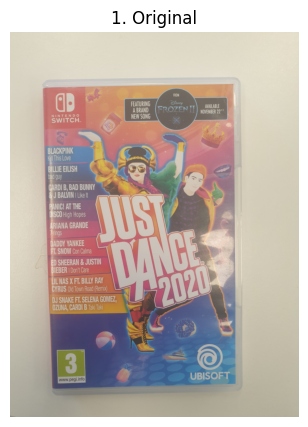

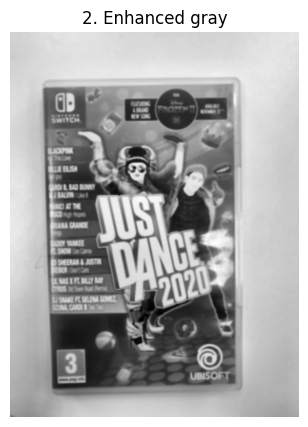

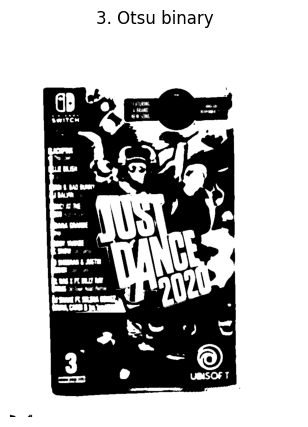

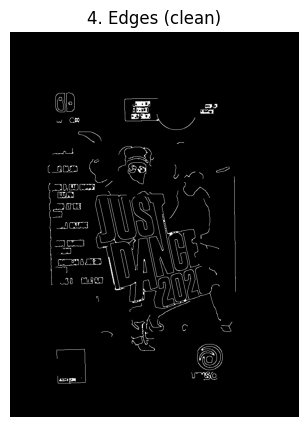

In [4]:
input_path = "test.jpg"  # <- change to your actual file
processed = clean_input_image(input_path)

# Visual checks (you can comment some out)
show_img("1. Original", processed["original"])
show_img("2. Enhanced gray", processed["enhanced"])
show_img("3. Otsu binary", processed["binary"])
show_img("4. Edges (clean)", processed["edges"])